In [1]:
import os
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from pathlib import Path
import cv2 as cv

In [2]:
def check_jpg_counts(path):
    cnt = 0
    for dir_name in os.listdir(path):
        dir_path = os.path.join(path, dir_name)
        if os.path.isdir(dir_path):
            jpg_count = sum(1 for f in os.listdir(dir_path) if f.endswith(".jpg"))
            if jpg_count != 170:
                print(f"file {dir_name} has {jpg_count} number .jpg")
            cnt += jpg_count
    print('other files each 170 number .jpg')
    print(f"total {cnt} number .jpg")


# check the number of .jpg files in each directory
_dataset_dir = "./data/PIE"
check_jpg_counts(_dataset_dir)

file 38 has 164 number .jpg
other files each 170 number .jpg
total 11554 number .jpg


In [3]:
test_tfm = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # change own image to 1 channel
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])


class FaceDataset(Dataset):

    def __init__(self, path, tfm=test_tfm, files=None):
        super(FaceDataset, self).__init__()
        self.path = path
        self.files = self._get_all_files(path) if files is None else files
        if len(self.files) == 0:
            raise ValueError(f"No .jpg files found in {path}")
        print(f"One {path} sample", self.files[0])
        self.transform = tfm

    def _get_all_files(self, path):
        """Recursively get all jpg files."""
        file_list = []
        for root, dirs, files in os.walk(path):
            for file in files:
                if file.endswith('.jpg'):
                    file_list.append(os.path.join(root, file))
        return sorted(file_list)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        im = Image.open(fname)
        if self.transform:
            im = self.transform(im)
        try:
            label = int(fname.split("/")[-2])  # adjusted to get the parent directory as label
        except:
            label = -1  # test has no label
        return im, label



In [4]:
num_subject = 25
seed = 202311172359
subjects_index = np.random.default_rng(seed).choice(np.arange(1, 69), num_subject, replace=False)

image_data = []
label_data = []

directory = Path("../ca2/data/PIE")
for i in subjects_index:
    images_folder = []
    labels_folder = []
    sub_file = directory / str(i)

    files = list(sub_file.glob("*.jpg"))
    np.random.default_rng(seed).shuffle(files)
    for filename in files:
        image0 = Image.open(filename)
        images_folder.append(np.array(image0))
        labels_folder.append(i)
    image_data.append(images_folder)
    label_data.append(labels_folder)

print(subjects_index)

[18 46 32 42  6 15 33 64 23 39  7 54 53 28 58 11  3 17 52  2 67 49 20 66
 50]


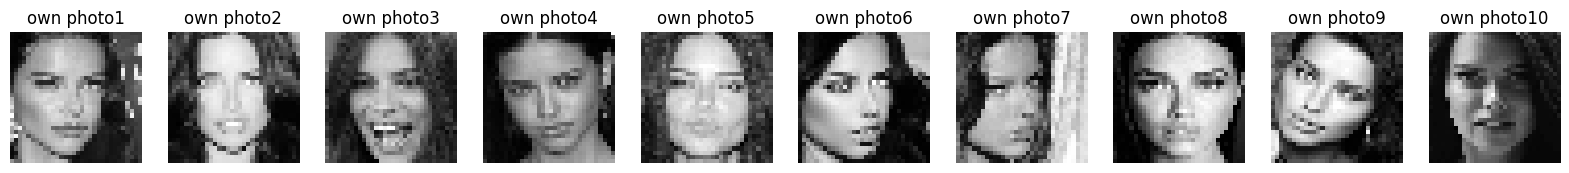

In [5]:
own_image_data = []
own_label_data = []

for i in range(1, 10 + 1):
    img = cv.imread('../ca2/data/own/69/' + str(i) + '.jpg', cv.IMREAD_GRAYSCALE)
    img = cv.resize(img, (32, 32), interpolation=cv.INTER_CUBIC)
    own_image_data.append(img)
    own_label_data.append(69)

# Split own photos into train and test sets
own_train_image_data = own_image_data[0:7]
own_test_image_data = own_image_data[7:]
own_train_label_data = own_label_data[0:7]
own_test_label_data = own_label_data[7:]

fig = plt.figure(figsize=(20, 10))

for i in range(1, 11):
    plt.subplot(1, 10, i)
    plt.imshow(own_image_data[i - 1], cmap='gray')
    plt.title('own photo' + str(i))
    plt.axis('off')

plt.show()

In [6]:
# Split PIE images into train and test sets
train_data_rate = np.int_(np.around(0.7 * 170))

image_data_train, image_data_test = np.split(np.array(image_data), [train_data_rate], axis=1)
label_data_train, label_data_test = np.split(np.array(label_data), [train_data_rate], axis=1)
own_image_data_train, own_image_data_test = np.split(np.array(own_image_data), [7])
own_label_data_train, own_label_data_test = np.split(np.array(own_label_data), [7])

import warnings
# ignore warnings for this part
warnings.filterwarnings('ignore', category=Warning)
flatten_dim = 32 * 32
# Reshape to 2D arrays
main_image_data_train = image_data_train.reshape(num_subject * train_data_rate, flatten_dim)
own_image_data_train = own_image_data_train.reshape(7, flatten_dim)
image_data_test = image_data_test.reshape(num_subject * (170 - train_data_rate), flatten_dim)
own_image_data_test = own_image_data_test.reshape(3, flatten_dim)

label_data_train = label_data_train.reshape(num_subject * train_data_rate)
label_data_test = label_data_test.reshape(num_subject * (170 - train_data_rate))

# Combine PIE and own photos
full_train_image_set = np.append(main_image_data_train, own_image_data_train, axis=0, )
full_train_label_set = np.append(label_data_train, own_label_data_train)

full_test_image_set = np.append(image_data_test, own_image_data_test, axis=0, )
full_test_label_set = np.append(label_data_test, own_label_data_test)

In [7]:
print(len(full_train_image_set))
num_samples = 500
sample_index = np.random.default_rng(seed).choice(np.arange(len(full_train_image_set)), num_samples, replace=False)

x_train = full_train_image_set[sample_index]
y_train = full_train_label_set[sample_index]

2982


In [8]:
class PCA:
    def __init__(self):
        pass

    def fit(self, X, n_components):
        X = X.reshape(-1, 32 * 32)
        mean_X = X.mean(axis=0)
        centered_X = X - mean_X

        u, s, vt = np.linalg.svd(centered_X, full_matrices=False)
        s_matrix = np.diag(s)

        # max components: 200
        X_pca = u[:, :n_components] @ s_matrix[:n_components, :n_components]

        return u, s, vt, X_pca

In [9]:
pca = PCA()  # initialize PCA

In [10]:
u, s, vt, X_pca = pca.fit(x_train, 200)  # fit PCA

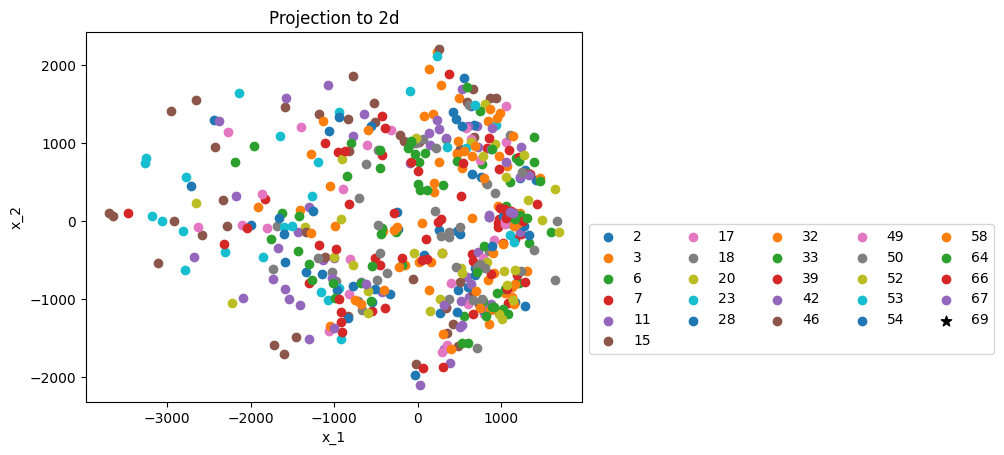

In [11]:
fig = plt.figure()
ax = fig.add_subplot()
for i in np.unique(y_train):
    ax.scatter(X_pca[y_train == i][:, 0], X_pca[y_train == i][:, 1], label=i)
ax.scatter(X_pca[y_train == 69][:, 0], X_pca[y_train == 69][:, 1], marker="*", label=69, c="k", s=60)

ax.set_xlabel("x_1")
ax.set_ylabel("x_2")
lgd = ax.legend(ncol=np.int_(num_subject / 5), bbox_to_anchor=(1, 0.5))
ax.set_title('Projection to 2d')
plt.show()

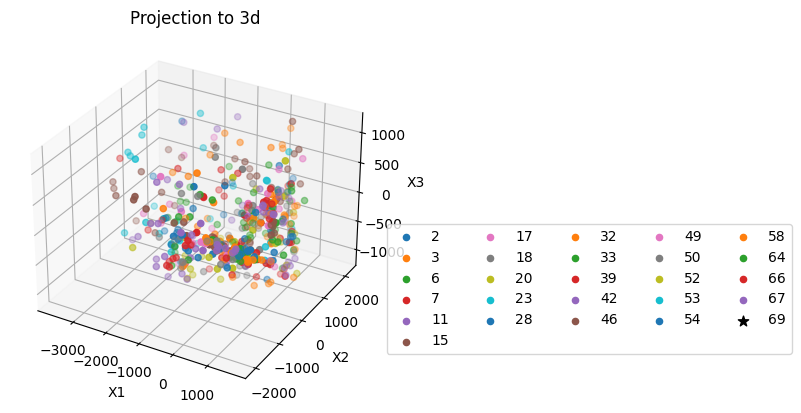

In [12]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
for i in np.unique(y_train):
    ax.scatter(X_pca[y_train == i][:, 0], X_pca[y_train == i][:, 1], X_pca[y_train == i][:, 2], label=i, )
ax.scatter(X_pca[y_train == 69][:, 0], X_pca[y_train == 69][:, 1], X_pca[y_train == 69][:, 2],
           marker="*", label=69, c="k", s=60, )
ax.set_xlabel("X1")
ax.set_ylabel("X2")
ax.set_zlabel("X3")

lgd = ax.legend(ncol=np.int_(num_subject / 5), bbox_to_anchor=(1, 0.5))
ax.set_title('Projection to 3d')
plt.show()

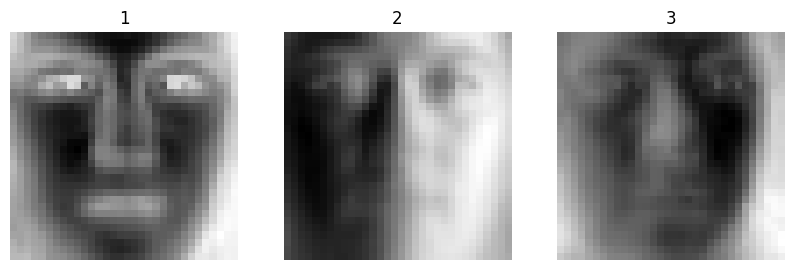

In [13]:
def TransformEigenface(eigenface):
    norm = ((eigenface - np.min(eigenface)) / (np.max(eigenface) - np.min(eigenface)) * 255)
    return Image.fromarray(norm.astype("uint8").reshape(32, 32), "L")


# Plot first 3 eigenfaces
faces = 3
fig = plt.figure(figsize=(10, 10))
for i in range(faces):
    face = TransformEigenface(vt[i])
    plt.subplot(1, 3, i + 1)
    plt.imshow(face, cmap='gray')
    plt.title(str(i + 1))
    plt.axis('off')
plt.show()

In [14]:
X_test_mean = np.mean(image_data_test, axis=0)
X_test_norm = image_data_test - X_test_mean

# own photos center
own_X_test_mean = np.mean(own_image_data_test, axis=0)
own_X_test_norm = own_image_data_test - own_X_test_mean

# projection to 200 dim
X_project_test = X_test_norm @ vt.T[:, :200]
own_project_test = own_X_test_norm @ vt.T[:, :200]

In [15]:
def compute_accuracy(X, y):
    # KNN classification
    def knn_classification(dim, X, y):
        dat = np.argsort(np.linalg.norm(X[:, :dim][:, np.newaxis] - X_pca[:, :dim], axis=2))
        k = 1  # k nearest neighbors
        index = dat[:, :k]
        nn_labels = y_train[index]
        result = nn_labels[:, 0]
        acc = np.sum(result == y) / y.size
        return acc
    # Compute accuracy
    for i in [40, 80, 200]:
        print("Accuracy -- dim", i, ":", knn_classification(i, X, y))


In [16]:
print("For pie:")
compute_accuracy(X_project_test, label_data_test)
print("For own:")
compute_accuracy(own_project_test, own_label_data_test)

For pie:
Accuracy -- dim 40 : 0.5309803921568628
Accuracy -- dim 80 : 0.5701960784313725
Accuracy -- dim 200 : 0.5843137254901961
For own:
Accuracy -- dim 40 : 0.0
Accuracy -- dim 80 : 0.0
Accuracy -- dim 200 : 0.0
